#### Introduction

BUSINESS PROBLEM:- An athelete and sports enthusasit student is shifting from his home country to toronto for higher studies so as result he/she is searching for home rent near places where sports/fitness areas are located in close proximity. For this reason he has contacted a real estate agent to ease out his work. This project will recommend the areas to the real estate agent where he/she can allocate a home for rent to the student.This project will be help the real estate agent in providing better quality of service by allocating proper homes for rent to its customer.

Audinece/User- Sports enthusasit students looking for home to rent.

Data Requirements
1)Toronto Postal Code and Neighborhood data will be used from the wiki page - https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
2)Geo Coordinates will be used from the csv file provided - 'Geospatial_Coordinates.csv'
3)Foursquare Data will be used to analyze different venues in the neighborhoods

In [11]:
import requests
import urllib.request
import numpy as np 

import pandas as pd 

import json # library to handle JSON files

from geopy.geocoders import Nominatim 

from bs4 import BeautifulSoup 

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt


!conda install -c conda-forge folium=0.5.0 --yes
import folium


from sklearn.cluster import KMeans


print("Libraries imported.")

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Scraping datafrom wikipedia page into dataframe

In [12]:

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = urllib.request.urlopen(url)

In [13]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page, "lxml")

all_tables = soup.find_all("table")
all_tables

[<table class="wikitable sortable">
 <tbody><tr>
 <th>Postcode</th>
 <th>Borough</th>
 <th>Neighbourhood
 </th></tr>
 <tr>
 <td>M1A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>
 <tr>
 <td>M2A</td>
 <td>Not assigned</td>
 <td>Not assigned
 </td></tr>
 <tr>
 <td>M3A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
 </td></tr>
 <tr>
 <td>M4A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
 </td></tr>
 <tr>
 <td>M5A</td>
 <td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
 <td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
 </td></tr>
 <tr>
 <td>M6A</td>
 <td><a href="/wiki/North_York" title="North York">North York</a></td>
 <td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
 </td></tr>
 <tr>


In [14]:
right_table = soup.find('table', class_='wikitable sortable')
right_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Harbourfront</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Lawrence_Heights" title="Lawrence Heights">Lawrence Heights</a>
</td></tr>
<tr>
<td>M6A</td>
<td><a href="/wiki/North

In [15]:

A=[]
B=[]
C=[]

for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))

In [16]:
import pandas as pd
df=pd.DataFrame(A,columns=['Postal_Code'])
df['Borough']=B
df['Neighborhoods']=C
df.head()

,Postal_Code,Borough,Neighborhoods
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [17]:
#Drop cells with a borough that is "Not assigned"
df_dropna = df[df.Borough != "Not assigned"].reset_index(drop=True)
df_dropna.head()

,Postal_Code,Borough,Neighborhoods
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [18]:

#Grouping neighborhoods in the same borough
df_grouped = df_dropna.groupby(["Postal_Code", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
df_grouped.head()

,Postal_Code,Borough,Neighborhoods
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood\n, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae\n


In [19]:
#Make the value of neighborhood as same as Borough when neighborhood="Not assigned"
for index, row in df_grouped.iterrows():
    if row["Neighborhoods"] == "Not assigned":
        row["Neighborhoods"] = row["Borough"]
        
df_grouped.head()

,Postal_Code,Borough,Neighborhoods
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood\n, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae\n


In [20]:

#shape of the final dataframe
df_grouped.shape

(103, 3)

#### Load the coordinates from the csv file and merge two tables to get the coordinates

In [21]:

coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [22]:

coordinates.rename(columns={"Postal Code": "Postal_Code"}, inplace=True)
coordinates.head()

,Postal_Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:

df_new = df_grouped.merge(coordinates, on="Postal_Code", how="left")
df_new.head()

,Postal_Code,Borough,Neighborhoods,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood\n, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae\n,43.773136,-79.239476


#### Use geopy library to get the latitude and longitude values of Toronto

In [24]:

#In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent my-application, as shown below.
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Creating a map of Toronto with neighborhoods superimposed on top.

In [25]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhoods in zip(df_new['Latitude'], df_new['Longitude'], df_new['Borough'], df_new['Neighborhoods']):
    label = '{}, {}'.format(neighborhoods, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

#### Foursquare API and credentials

In [50]:

CLIENT_ID = 'Your Id' # your Foursquare ID
CLIENT_SECRET = 'Your Scret Id' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Your Id
CLIENT_SECRET:Your Scret Id


#### Let's create a function to get top 100 venues the neighborhoods in Toronto

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Converting the venues list into a new DataFrame

In [28]:
toronto_venues = getNearbyVenues(names=df_new['Neighborhoods'],
                                   latitudes=df_new['Latitude'],
                                   longitudes=df_new['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood
, Morningside, West Hill
Woburn
Cedarbrae

Scarborough Village
East Birchmount Park
, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West

Birch Cliff, Cliffside West

Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners
, Sullivan
, Tam O'Shanter
Agincourt North, L'Amoreaux East
, Milliken, Steeles East

L'Amoreaux West

Upper Rouge
Hillcrest Village
Fairview
, Henry Farm, Oriole

Bayview Village
Silver Hills
, York Mills
Newtonbrook, Willowdale
Willowdale South

York Mills West

Willowdale West
Parkwoods
Don Mills North

Flemingdon Park, Don Mills South

Bathurst Manor, Downsview North
, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East

Downsview West
Downsview Central

Downsview Northwest

Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toront

In [29]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood\n, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood\n, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [30]:
# check how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide\n, King\n, Richmond\n",100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East\n, Milliken, Steeles East\n",3,3,3,3,3,3
"Albion Gardens\n, Beaumond Heights, Humbergate\n, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",7,7,7,7,7,7
"Alderwood, Long Branch",10,10,10,10,10,10
...,...,...,...,...,...,...
Willowdale West,6,6,6,6,6,6
Woburn,3,3,3,3,3,3
"Woodbine Gardens, Parkview Hill",13,13,13,13,13,13


In [31]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 277 uniques categories.


In [32]:

toronto_venues['Venue Category'].unique()

array(['Fast Food Restaurant', 'Golf Course', 'Bar', 'Pizza Place',
       'Electronics Store', 'Spa', 'Mexican Restaurant',
       'Rental Car Location', 'Medical Center', 'Intersection',
       'Breakfast Spot', 'Coffee Shop', 'Korean Restaurant',
       'Hakka Restaurant', 'Caribbean Restaurant', 'Thai Restaurant',
       'Bank', 'Athletics & Sports', 'Gas Station', 'Bakery',
       'Fried Chicken Joint', 'Playground', 'Grocery Store',
       'Department Store', 'Hobby Shop', 'Discount Store', 'Bus Station',
       'Bus Line', 'Metro Station', 'Park', 'Soccer Field', 'Motel',
       'American Restaurant', 'Café', 'General Entertainment',
       'Skating Rink', 'College Stadium', 'Indian Restaurant',
       'Chinese Restaurant', 'Pet Store', 'Vietnamese Restaurant',
       'Smoke Shop', 'Middle Eastern Restaurant',
       'Latin American Restaurant', 'Lounge', 'Clothing Store',
       'Italian Restaurant', 'Noodle House', 'Pharmacy', 'Sandwich Place',
       'Cosmetics Shop', 'Bubble

#### Below are the concerned venue categories:

Park, Gym, Gym / Fitness Center, Sporting Goods Shop, Yoga Studio, Playground, Trail, Baseball Field, Athletics & Sports, Pool, Basketball Stadium, Hockey Arena, Baseball Stadium, Skate Park, Soccer Field, Stadium.

In [33]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2224, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood\n, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood\n, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [34]:
toronto_grouped = toronto_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(100, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide\n, King\n, Richmond\n",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,...,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,"Agincourt North, L'Amoreaux East\n, Milliken, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,"Albion Gardens\n, Beaumond Heights, Humbergate...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


#### Create new dataframe for recreational event categories

In [35]:
toronto_recr = toronto_grouped[["Neighborhoods","Park","Gym","Gym / Fitness Center","Yoga Studio","Playground","Trail","Baseball Field","Athletics & Sports","Pool","Basketball Stadium","Hockey Arena","Baseball Stadium","Skate Park","Soccer Field","Stadium"]]
toronto_recr.head()

,Neighborhoods,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium
0,"Adelaide\n, King\n, Richmond\n",0.000000,0.02,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.000000,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agincourt North, L'Amoreaux East\n, Milliken, ...",0.333333,0.00,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Albion Gardens\n, Beaumond Heights, Humbergate...",0.000000,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Alderwood, Long Branch",0.000000,0.10,0.00,0.0,0.000000,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0


### Cluster Neighborhoods

#### Run k-means to cluster the neighborhoods in Toronto into 3 clusters.

In [36]:
# set number of clusters
torontoclusters = 3

toronto_clustering = toronto_recr.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=torontoclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [37]:
# create a new dataframe that includes the cluster 
toronto_merged = toronto_recr.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

toronto_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
toronto_merged.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels
0,"Adelaide\n, King\n, Richmond\n",0.000000,0.02,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Agincourt,0.000000,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,"Agincourt North, L'Amoreaux East\n, Milliken, ...",0.333333,0.00,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,"Albion Gardens\n, Beaumond Heights, Humbergate...",0.000000,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,"Alderwood, Long Branch",0.000000,0.10,0.00,0.0,0.000000,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0


In [38]:
df_new.head()
toronto_lookup = df_new.drop(['Postal_Code', 'Borough'], axis=1)
toronto_lookup.head()

,Neighborhoods,Latitude,Longitude
0,"Rouge, Malvern",43.806686,-79.194353
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,"Guildwood\n, Morningside, West Hill",43.763573,-79.188711
3,Woburn,43.770992,-79.216917
4,Cedarbrae\n,43.773136,-79.239476


In [39]:
# merge toronto_grouped with toronto_lookup to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_lookup.set_index("Neighborhoods"), on="Neighborhood")
toronto_merged.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude
0,"Adelaide\n, King\n, Richmond\n",0.000000,0.02,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.650571,-79.384568
1,Agincourt,0.000000,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.794200,-79.262029
2,"Agincourt North, L'Amoreaux East\n, Milliken, ...",0.333333,0.00,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,43.815252,-79.284577
3,"Albion Gardens\n, Beaumond Heights, Humbergate...",0.000000,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.739416,-79.588437
4,"Alderwood, Long Branch",0.000000,0.10,0.00,0.0,0.000000,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0,43.602414,-79.543484


In [40]:
# sort the results by Cluster Labels
toronto_merged = toronto_merged.sort_values(["Cluster Labels"]).reset_index(drop = True)
toronto_merged

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude
0,"Adelaide\n, King\n, Richmond\n",0.000000,0.020000,0.01,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.650571,-79.384568
1,Not assigned\n,0.051282,0.051282,0.00,0.025641,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.662301,-79.389494
2,"Northwood Park, York University",0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.767980,-79.487262
3,Northwest\n,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.706748,-79.594054
4,North Toronto West\n,0.050000,0.000000,0.05,0.050000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,43.715383,-79.405678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"CFB Toronto, Downsview East\n",0.500000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,43.737473,-79.464763
96,York Mills West\n,0.500000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,43.752758,-79.400049
97,Downsview Central\n,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,43.728496,-79.495697
98,"Humber Bay, King's Mill Park\n, Kingsway Park ...",0.000000,0.000000,0.00,0.000000,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,43.636258,-79.498509


In [41]:
#Group the data by Cluster Labels 
toronto_clus_report = toronto_merged.groupby(["Cluster Labels"]).sum().reset_index()
toronto_clus_report

,Cluster Labels,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,Basketball Stadium,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Latitude,Longitude
0,0,1.190107,0.957664,0.720635,0.32952,1.176757,0.523256,0.216129,0.616302,0.350000,0.047748,0.5,0.02,0.058824,0.1,0.047619,3627.149491,-6589.281880
1,1,5.033333,0.000000,0.000000,0.00000,0.583333,0.500000,0.000000,0.000000,0.333333,0.000000,0.0,0.00,0.000000,0.0,0.000000,612.042552,-1111.952050
2,2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.333333,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,131.089520,-238.526449


In [42]:
#Transpose the data frame for plotting chart on the data 
toronto_clus_pivot = toronto_clus_report.transpose()
toronto_clus_pivot.drop(['Cluster Labels', 'Latitude','Longitude'],inplace = True)
toronto_clus_pivot

,0,1,2
Park,1.190107,5.033333,0.000000
Gym,0.957664,0.000000,0.000000
Gym / Fitness Center,0.720635,0.000000,0.000000
Yoga Studio,0.329520,0.000000,0.000000
Playground,1.176757,0.583333,0.000000
Trail,0.523256,0.500000,0.000000
Baseball Field,0.216129,0.000000,1.333333
Athletics & Sports,0.616302,0.000000,0.000000
Pool,0.350000,0.333333,0.000000
Basketball Stadium,0.047748,0.000000,0.000000


In [43]:
toronto_clus_pivot.describe()

,0,1,2
count,15.000000,15.000000,15.000000
mean,0.456971,0.430000,0.088889
std,0.405766,1.289029,0.344265
min,0.020000,0.000000,0.000000
25%,0.079412,0.000000,0.000000
50%,0.350000,0.000000,0.000000
75%,0.668468,0.166667,0.000000
max,1.190107,5.033333,1.333333


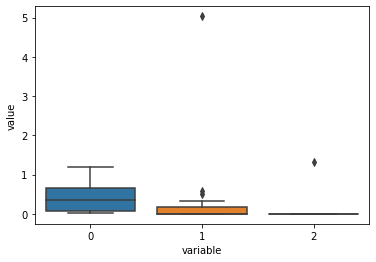

In [44]:
#Chart boxplot on all clusters
sns.boxplot(x="variable", y="value", data=pd.melt(toronto_clus_pivot))
plt.show()

Among all clusters cluster 0 has maximum occurances of venue which are related to Sporting Goods. Hence, this analysis can recommend the user to open the store in one of locations in Cluster 0.

#### Visualize the clusters

In [45]:
kclusters = 3
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

#### Deep Dive for precise recommendation.

Now that we have come to a point where we can recommend that Cluter 0 is safer to open a Sporting Goods store in a broad way, lets deep dive to the data to find out which neighborhoods are the best for the opportunity. Below analysis will give a result of top 5 neighborhoods based on maximum types and maximum number of sporting venues.

In [46]:
#Add Count of non zero occurance and sum of sporting venues in the dataframe
toronto_sc = toronto_merged
col_list= list(toronto_merged)
col_list.remove('Neighborhood')
col_list.remove('Cluster Labels')
col_list.remove('Latitude')
col_list.remove('Longitude')
col_list
toronto_sc['Sum'] = toronto_merged[col_list].sum(axis=1)
toronto_sc['Count'] = toronto_merged[col_list].gt(0).sum(axis=1)
toronto_sc.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,...,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude,Sum,Count
0,"Adelaide\n, King\n, Richmond\n",0.000000,0.020000,0.01,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,43.650571,-79.384568,0.030000,2
1,Not assigned\n,0.051282,0.051282,0.00,0.025641,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,43.662301,-79.389494,0.128205,3
2,"Northwood Park, York University",0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,43.767980,-79.487262,0.000000,0
3,Northwest\n,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,43.706748,-79.594054,0.000000,0
4,North Toronto West\n,0.050000,0.000000,0.05,0.050000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,43.715383,-79.405678,0.150000,3


In [47]:
#Sort the dataframe 
toronto_sort = toronto_sc.sort_values(["Count","Sum"],ascending = False).reset_index(drop = True)
toronto_sort.head()

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,...,Hockey Arena,Baseball Stadium,Skate Park,Soccer Field,Stadium,Cluster Labels,Latitude,Longitude,Sum,Count
0,"Dovercourt Village, Dufferin\n",0.055556,0.0,0.055556,0.000000,0.055556,0.00,0.0,0.055556,0.0,...,0.00,0.0,0.0,0.0,0.0,0,43.669005,-79.442259,0.222222,4
1,"Little Portugal, Trinity",0.016129,0.0,0.016129,0.016129,0.016129,0.00,0.0,0.000000,0.0,...,0.00,0.0,0.0,0.0,0.0,0,43.647927,-79.419750,0.064516,4
2,Rosedale,0.500000,0.0,0.000000,0.000000,0.250000,0.25,0.0,0.000000,0.0,...,0.00,0.0,0.0,0.0,0.0,1,43.679563,-79.377529,1.000000,3
3,Humewood-Cedarvale,0.000000,0.0,0.000000,0.000000,0.250000,0.25,0.0,0.000000,0.0,...,0.25,0.0,0.0,0.0,0.0,0,43.693781,-79.428191,0.750000,3
4,"Alderwood, Long Branch",0.000000,0.1,0.000000,0.000000,0.000000,0.00,0.0,0.100000,0.1,...,0.00,0.0,0.0,0.0,0.0,0,43.602414,-79.543484,0.300000,3


In [48]:
toronto_recom = toronto_sort.head()

#Join with neighborhood dataframe to plot the map
toronto_final = toronto_recom.join(df_new.set_index('Neighborhoods'), on='Neighborhood',lsuffix='_a', rsuffix='_b')
toronto_final

,Neighborhood,Park,Gym,Gym / Fitness Center,Yoga Studio,Playground,Trail,Baseball Field,Athletics & Sports,Pool,...,Stadium,Cluster Labels,Latitude_a,Longitude_a,Sum,Count,Postal_Code,Borough,Latitude_b,Longitude_b
0,"Dovercourt Village, Dufferin\n",0.055556,0.0,0.055556,0.000000,0.055556,0.00,0.0,0.055556,0.0,...,0.0,0,43.669005,-79.442259,0.222222,4,M6H,West Toronto,43.669005,-79.442259
1,"Little Portugal, Trinity",0.016129,0.0,0.016129,0.016129,0.016129,0.00,0.0,0.000000,0.0,...,0.0,0,43.647927,-79.419750,0.064516,4,M6J,West Toronto,43.647927,-79.419750
2,Rosedale,0.500000,0.0,0.000000,0.000000,0.250000,0.25,0.0,0.000000,0.0,...,0.0,1,43.679563,-79.377529,1.000000,3,M4W,Downtown Toronto,43.679563,-79.377529
3,Humewood-Cedarvale,0.000000,0.0,0.000000,0.000000,0.250000,0.25,0.0,0.000000,0.0,...,0.0,0,43.693781,-79.428191,0.750000,3,M6C,York,43.693781,-79.428191
4,"Alderwood, Long Branch",0.000000,0.1,0.000000,0.000000,0.000000,0.00,0.0,0.100000,0.1,...,0.0,0,43.602414,-79.543484,0.300000,3,M8W,Etobicoke,43.602414,-79.543484


In [49]:
# create map of Toronto Neighborhood whiah are recommended to rent a home
map_recom = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, PostalCode in zip(toronto_final['Latitude_a'], toronto_final['Longitude_a'], toronto_final['Borough'], toronto_final['Postal_Code']):
    label = '{}, {}'.format(PostalCode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=12,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_recom)  
    
map_recom

#### The top 5 recommended Neighborhoods to rent a home:

1)Business Reply Mail Processing Centre 969 Eastern.

2)Rosedale.

3)Moore Park, Summerhill East.

4)Thorncliffe Park.

5)Queen's Park.

#### Conclusion

The real estate agent should recommend the student to rent a home in the above stated neighbourhoods as according to his/her preferences these above stated neighborhoods have the maximum number of sports related areas.